In [2]:
import numpy as np
import pandas as pd
import os

import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, GridSearchCV
import lightgbm as lgb
import xgboost as xgb
from tensorflow import keras
import time
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from scipy.signal import hilbert
from scipy.signal import hann
from scipy.signal import convolve
from scipy import stats
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import NearestNeighbors
import librosa, librosa.display
import builtins
from sklearn.ensemble import RandomForestRegressor
import eli5
import shap
from sklearn.feature_selection import GenericUnivariateSelect, SelectPercentile, SelectKBest, f_classif, mutual_info_classif, RFE

/Users/norihumi-omi/opt/anaconda3/envs/omi/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [3]:
import altair as alt
import altair.vegalite.v3 as v3
from IPython.display import HTML
import json
# Preparing altair. I use code from this great kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey

vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {}
}});
"""

#------------------------------------------------ Defs for future rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
            
@add_autoincrement
def render(chart, id="vega-chart"):
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )

HTML("".join((
    "<script>",
    workaround.format(json.dumps(paths)),
    "</script>",
)))

In [4]:
os.listdir('../input/LANL_features')

['.DS_Store',
 'test',
 'train_features_denoised.csv',
 'test_features_denoised.csv',
 'test_features.csv',
 'train.csv',
 'y.csv',
 'train_features.csv',
 'sample_submission.csv']

In [5]:
train_features = pd.read_csv('../input/LANL_features/train_features.csv')
test_features = pd.read_csv('../input/LANL_features/test_features.csv')
train_features_denoised = pd.read_csv('../input/LANL_features/train_features_denoised.csv')
test_features_denoised = pd.read_csv('../input/LANL_features/test_features_denoised.csv')
train_features_denoised.columns = [f'{i}_denoised' for i in train_features_denoised.columns]
test_features_denoised.columns = [f'{i}_denoised' for i in test_features_denoised.columns]
y = pd.read_csv('../input/LANL_features/y.csv')

In [7]:

"""
This script contains functions, which I'll use in my kernels.

"""

# imports 
import os
import time
import datetime
import json
import gc

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

#import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
from sklearn import metrics

from itertools import product

import altair as alt
import altair.vegalite.v3 as v3
from IPython.display import HTML

# using ideas from this kernel: https://www.kaggle.com/notslush/altair-visualization-2018-stackoverflow-survey
def prepare_altair():
    """
    Helper function to prepare altair for working.
    """

    vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
    vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
    vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
    vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
    noext = "?noext"
    
    paths = {
        'vega': vega_url + noext,
        'vega-lib': vega_lib_url + noext,
        'vega-lite': vega_lite_url + noext,
        'vega-embed': vega_embed_url + noext
    }
    
    workaround = f"""    requirejs.config({{
        baseUrl: 'https://cdn.jsdelivr.net/npm/',
        paths: {paths}
    }});
    """
    
    return workaround
    

def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay outside and 
    return wrapped
           

@add_autoincrement
def render(chart, id="vega-chart"):
    """
    Helper function to plot altair visualizations.
    """
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vg_embed) {{
        const spec = {chart};     
        vg_embed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
        console.log("anything?");
    }});
    console.log("really...anything?");
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )
    

def train_model_regression(X, X_test, y, params, folds, model_type='lgb', eval_metric='mae', columns=None, plot_feature_importance=False, model=None):
    """
    A function to train a variety of regression models.
    Returns dictionary with oof predictions, test predictions, scores and, if necessary, feature importances.
    
    :params: X - training data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: X_test - test data, can be pd.DataFrame or np.ndarray (after normalizing)
    :params: y - target
    :params: folds - folds to split data
    :params: model_type - type of model to use
    :params: eval_metric - metric to use
    :params: columns - columns to use. If None - use all columns
    :params: plot_feature_importance - whether to plot feature importance of LGB
    :params: model - sklearn model, works only for "sklearn" model type
    
    """
    columns = X.columns if columns == None else columns
    X_test = X_test[columns]
    
    # to set up scoring parameters
    metrics_dict = {'mae': {'lgb_metric_name': 'mae',
                        'catboost_metric_name': 'MAE',
                        'sklearn_scoring_function': metrics.mean_absolute_error}}
    
    result_dict = {}
    
    # out-of-fold predictions on train data
    oof = np.zeros(len(X))
    
    # averaged predictions on train data
    prediction = np.zeros(len(X_test))
    
    # list of scores on folds
    scores = []
    feature_importance = pd.DataFrame()
    
    # split and train on folds
    for fold_n, (train_index, valid_index) in enumerate(folds.split(X)):
        print(f'Fold {fold_n + 1} started at {time.ctime()}')
        if type(X) == np.ndarray:
            X_train, X_valid = X[columns][train_index], X[columns][valid_index]
            y_train, y_valid = y[train_index], y[valid_index]
        else:
            X_train, X_valid = X[columns].iloc[train_index], X[columns].iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            
        if model_type == 'lgb':
            model = lgb.LGBMRegressor(**params, n_estimators = 50000, n_jobs = -1)
            model.fit(X_train, y_train, 
                    eval_set=[(X_train, y_train), (X_valid, y_valid)], eval_metric=metrics_dict[eval_metric]['lgb_metric_name'],
                    verbose=10000, early_stopping_rounds=200)
            
            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test, num_iteration=model.best_iteration_)
            
        if model_type == 'xgb':
            train_data = xgb.DMatrix(data=X_train, label=y_train, feature_names=X.columns)
            valid_data = xgb.DMatrix(data=X_valid, label=y_valid, feature_names=X.columns)

            watchlist = [(train_data, 'train'), (valid_data, 'valid_data')]
            model = xgb.train(dtrain=train_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200, verbose_eval=500, params=params)
            y_pred_valid = model.predict(xgb.DMatrix(X_valid, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
            y_pred = model.predict(xgb.DMatrix(X_test, feature_names=X.columns), ntree_limit=model.best_ntree_limit)
        
        if model_type == 'sklearn':
            model = model
            model.fit(X_train, y_train)
            
            y_pred_valid = model.predict(X_valid).reshape(-1,)
            score = metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid)
            print(f'Fold {fold_n}. {eval_metric}: {score:.4f}.')
            print('')
            
            y_pred = model.predict(X_test).reshape(-1,)
        
        if model_type == 'cat':
            model = CatBoostRegressor(iterations=20000,  eval_metric=metrics_dict[eval_metric]['catboost_metric_name'], **params,
                                      loss_function=metrics_dict[eval_metric]['catboost_metric_name'])
            model.fit(X_train, y_train, eval_set=(X_valid, y_valid), cat_features=[], use_best_model=True, verbose=False)

            y_pred_valid = model.predict(X_valid)
            y_pred = model.predict(X_test)
        
        oof[valid_index] = y_pred_valid.reshape(-1,)
        scores.append(metrics_dict[eval_metric]['sklearn_scoring_function'](y_valid, y_pred_valid))

        prediction += y_pred    
        
        if model_type == 'lgb' and plot_feature_importance:
            # feature importance
            fold_importance = pd.DataFrame()
            fold_importance["feature"] = columns
            fold_importance["importance"] = model.feature_importances_
            fold_importance["fold"] = fold_n + 1
            feature_importance = pd.concat([feature_importance, fold_importance], axis=0)

    prediction /= folds.n_splits
    
    print('CV mean score: {0:.4f}, std: {1:.4f}.'.format(np.mean(scores), np.std(scores)))
    
    result_dict['oof'] = oof
    result_dict['prediction'] = prediction
    result_dict['scores'] = scores
    
    if model_type == 'lgb':
        if plot_feature_importance:
            feature_importance["importance"] /= folds.n_splits
            cols = feature_importance[["feature", "importance"]].groupby("feature").mean().sort_values(
                by="importance", ascending=False)[:50].index

            best_features = feature_importance.loc[feature_importance.feature.isin(cols)]

            plt.figure(figsize=(16, 12));
            sns.barplot(x="importance", y="feature", data=best_features.sort_values(by="importance", ascending=False));
            plt.title('LGB Features (avg over folds)');
            
            result_dict['feature_importance'] = feature_importance
        
    return result_dict

In [8]:
X = pd.concat([train_features, train_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X_test = pd.concat([test_features, test_features_denoised], axis=1).drop(['seg_id_denoised', 'target_denoised'], axis=1)
X = X[:-1]
y = y[:-1]

In [9]:
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=11)

Fold 1 started at Sat Feb  1 10:37:36 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[479]	training's l1: 1.37752	valid_1's l1: 2.08836
Fold 2 started at Sat Feb  1 10:38:01 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[931]	training's l1: 0.972173	valid_1's l1: 2.01816
Fold 3 started at Sat Feb  1 10:38:36 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[339]	training's l1: 1.53521	valid_1's l1: 2.13
Fold 4 started at Sat Feb  1 10:38:51 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[449]	training's l1: 1.4437	valid_1's l1: 1.91318
Fold 5 started at Sat Feb  1 10:39:12 2020
Training until validation scores don't improve for 200 rounds
Early stopping, best iteration is:
[543]	training's l1: 1.30452	valid_1's l1: 2.0554
CV mean score: 2.0410, std: 0.0738.
             

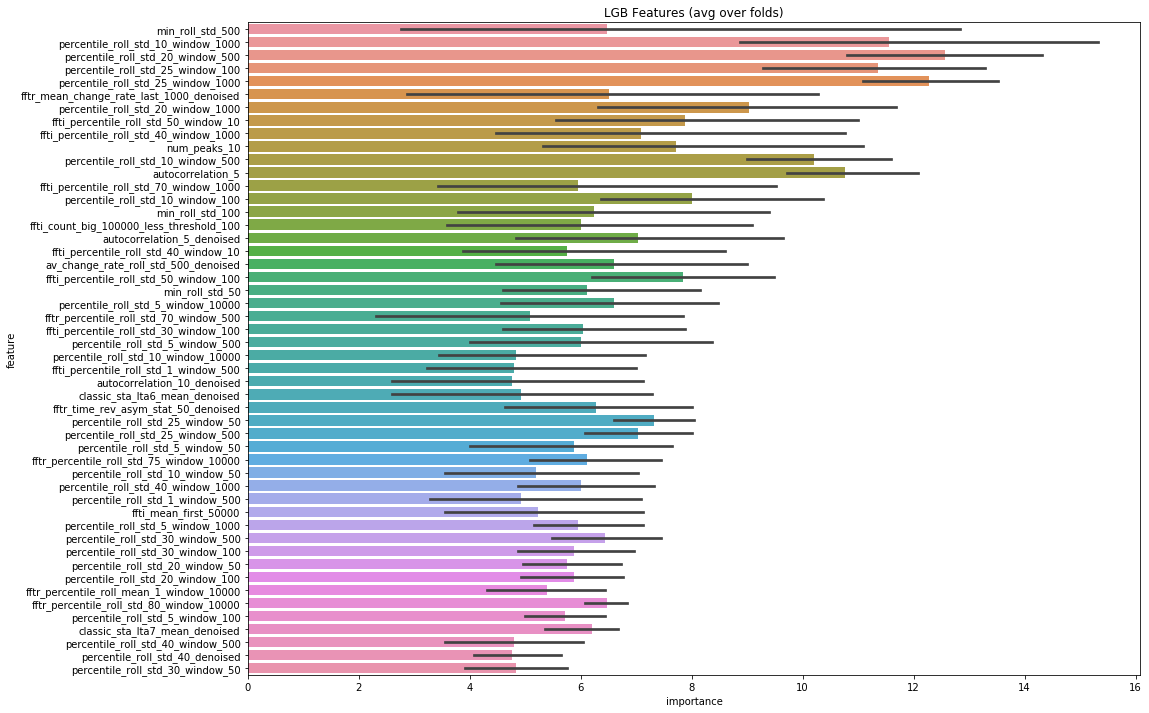

In [10]:
params = {'num_leaves': 128,
          'min_child_samples': 79,
          'max_depth': -1,
          'learning_rate': 0.01,
          "boosting_type": "gbdt",
          "subsample_freq": 5,
          "subsample": 0.9,
          "bagging_seed": 11,
          "metric": 'mae',
          "verbosity": -1,
          'reg_alpha': 0.1302650970728192,
          'reg_lambda': 0.3603427518866501,
          'colsample_bytree': 0.1
         }
result_dict_lgb = train_model_regression(X=X, X_test=X_test, y=y, params=params, folds=folds, model_type='lgb',
                                                                                  eval_metric='mae', plot_feature_importance=True)

submission = pd.read_csv('../input/LANL-Earthquake-Prediction/sample_submission.csv', index_col='seg_id')
submission['time_to_failure'] = result_dict_lgb['prediction']
print(submission.head())
submission.to_csv('submission2.csv')

In [11]:
def create_model(input_dim=10):
    model = keras.Sequential()
    model.add(keras.layers.Dense(256, activation="relu", input_dim=input_dim))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(128, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(96, activation="relu"))
    model.add(keras.layers.Dropout(0.3))
    model.add(keras.layers.Dense(1, activation="linear"))

    optimizer = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
    model.compile(optimizer=optimizer, loss='mae')

    return model

patience = 50
call_ES = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=patience, verbose=1, mode='auto', baseline=None, restore_best_weights=True)

In [33]:
%%time
n_fold = 2
folds = KFold(n_splits=n_fold, shuffle=True, random_state=42)

NN_oof = np.zeros(len(X))
train_score = []
NN_predictions = np.zeros(len(X_test))

for fold_, (trn_idx, val_idx) in enumerate(folds.split(X, y.values)):
    print("fold {}".format(fold_))
    
    X_tr, X_val = X.iloc[trn_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[trn_idx], y.iloc[val_idx]
    model = create_model(X.shape[-1])
    model.fit(X_tr, y_tr, epochs=500, batch_size=32, verbose=0, callbacks=[call_ES,], validation_data=[X_val, y_val])
    NN_oof[val_idx] = model.predict(X_val)[:, 0]
    
    NN_predictions += model.predict(X_test)[:, 0] / folds.n_splits
    history = model.history.history
    tr_loss = history["loss"]
    val_loss = history["val_loss"]
    print(f"loss: {tr_loss[-patience]:.3f} | val_loss: {val_loss[-patience]:.3f} | diff: {val_loss[-patience]-tr_loss[-patience]:.3f}")
    train_score.append(tr_loss[-patience])
    
cv_score = mean_absolute_error(y, NN_oof)
print(f"After {n_fold}: test_CV = {cv_score:.3f} | train_CV = {np.mean(train_score):.3f} | {cv_score-np.mean(train_score):.3f}", end=" ")

fold 0
Restoring model weights from the end of the best epoch.
Epoch 00077: early stopping
loss: 70321752395737.758 | val_loss: 3.040 | diff: -70321752395734.719
fold 1
Restoring model weights from the end of the best epoch.
Epoch 00352: early stopping
loss: 3.056 | val_loss: 3.040 | diff: -0.016
After 2: test_CV = 3.040 | train_CV = 35160876197870.406 | -35160876197867.367 CPU times: user 56min 1s, sys: 47min 26s, total: 1h 43min 27s
Wall time: 27min 41s
